## Fáza 2 - predspracovanie údajov
 Autor: Martin Katkovčin

**Načítanie potrebných knižníc pre analýzu údajov**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, f_classif

from numpy import isnan
from numpy.random import seed 
from numpy import percentile

from datetime import date

import category_encoders as ce

**Funkcie, ktoré používame pri čistení dát**

In [3]:
def __column_description__(dataframe):
    for column in dataframe:
        print("Column name: " + str(column))
        print("Number of values: " +str(getattr(dataframe, column).shape[0]))
        print("Number of unique values: " + str(getattr(dataframe,str(column)).unique().__len__()))
        print("Number of NA values: " + str(getattr(dataframe, column).shape[0] - getattr(dataframe, column).dropna().shape[0]))
        print("")

Funkcia, kde zistíme, kde máme NA values a podľa toho budeme skúmať dané stĺpce a nahrádzať hodnoty podľa početnosti.

In [4]:
def __median__(dataframe, column):
    median = dataframe[column].median()
    dataframe[column].fillna(median, inplace = True)
   
    return dataframe

Funkcia, ktorá nahradí NA hodnoty v stĺpci strednou hodnotou (medián).

In [5]:
def __mean__(dataframe, column):
    mean = dataframe[column].mean()
    dataframe[column].fillna(mean, inplace = True)
    
    return dataframe

Funkcia, ktorá nahradí NA hodnoty v stĺpci priemerom hodnôt, ktoré sa nachádzajú v danom stĺpci.

In [6]:
def __fill_median__(dataframe, columns):
    for column in columns:
        dataframe = __median__(dataframe, column)
    
    return dataframe

Funkcia, ktorá naplní chýbajúce hodnoty mediánom.

In [7]:
def __fill_mean__(dataframe, columns):
    for column in columns:
        dataframe = __mean__(dataframe, column)
    
    return dataframe

Funkcia, ktorá naplní chýbajúce hodnoty priemerom.

In [8]:
def __zip__(dataframe, column):
    for element in range (len(dataframe[column])):
        code = str(dataframe[column][element])
        dataframe.loc[element, column] = code[len(code) - 5:len(code)]
    
    dataframe[column] = dataframe[column].astype('int')
    
    return dataframe

Pomocou funkcie získame PSČ a uložíme si do pôvodného záznamu.

In [9]:
def __age_calculation__(dataframe, column):
    today = date.today()
    dataframe[column] = dataframe[column].apply(lambda x: today.year - x.year - ((today.month, today.day) < (x.month, x.day)))
    
    return dataframe

Touto funckiou si vyrátame vek respondetov, ktorý sú v záznamoch, keďže nevieme, v akom roku bolo toto meranie realizované, tak môžeme si dať, že v roku 2020. Následne taktiež ak nám výjde záporný vek alebo mínusový, tka to budeme brať ako outliere a pomocou funkcie date-of-birth vypočítame nový vek, ale ak aj napriek tomu ostane vek záporný alebo trojciferný, tak tieto záznamy z dataframu vymažeme.

In [10]:
def __unify_rows__(dataframe):
    aggregation = {}
    
    for column in dataframe.columns:
        aggregation[column] = 'first'
    
    return dataframe.groupby(dataframe['name'], as_index = False).aggregate(aggregation)

Funkcia, ktorá zjednotí duplikáty.

In [11]:
def __cleanse__(dataframe, column, wf, wt):
    for element in range(len(wf)):
        dataframe.loc[dataframe[column] == wf[element], column] = wt

Pomocou tejto funkcie, vieme rôzne hodnoty zmeniť na jednú unikátnu, napr. pri hodnote smoker, tak vieme zmeniť Y na 1 a N na 0, pretože potrebujeme binárne rozdeľovať pri strojovom učení prostredníctvom numerických hodnôt.

In [12]:
def __unify_values__(dataframe):
    unify = Pipeline([
        ('1. step', __cleanse__(dataframe, 'smoker', ["yes", "Y"], "y")),
        ('2. step', __cleanse__(dataframe, 'smoker', ["no", "N"], "n")),
        
        ('3. step', __cleanse__(dataframe, 'relationship', ["divoced", "widowed"], "single")),
        ('4. step', __cleanse__(dataframe, 'relationship', ["separated"], "married")),
        ('5. step', __cleanse__(dataframe, 'relationship', ["nop"], "not specified")),
    ])
    
    unify = unify.fit(dataframe)
    dataframe = unify.transform(dataframe)
    
    return dataframe

V tejto funkcii sme využile Pipelinu, prostredníctvom ktorej sme každý atribút, kde si myslíme, že bolo vhodné, aby sme zjednotili dáta.

In [13]:
def __format_date__(dataframe, column):
    dataframe[column] = dataframe.birthdate.apply(lambda x: pd.to_datetime(x).strftime("%Y/%m/%d"))
    
    return dataframe

Zjednotíme formát dátumov YYYY-MM-DD.

In [14]:
def __birthdate_to_date__(dataframe, column):
    dataframe[column] = pd.to_datetime(dataframe[column])
    
    return dataframe

Zmena typu birthdate zo string na date.

In [15]:
def __transform__(dataframe, columns):
    for col in columns:
        data = dataframe[col].values.reshape(-1, 1)
        power = PowerTransformer(method = 'yeo-johnson', standardize = True) 
        dataframe[col] = power.fit_transform(data)
        
    return dataframe

Transformovanie numerických dát, aby boli lepšie distribuované prostredníctvom metódy Yeo-Johnson, pretože dokáže pracovať aj s negatívnými hodnotami.

In [16]:
def __encoding__(dataframe, column, typ):
    data = dataframe[column]

    if typ == 0:
        ce_ordinal = ce.OneHotEncoder(cols=[column])
        dataframe[column] = ce_ordinal.fit_transform(data)
        
    elif typ == 1:
        ce_ordinal = ce.OrdinalEncoder(cols=[column])
        dataframe[column] = ce_ordinal.fit_transform(data)
    
    return dataframe

Prostredníctvom funkcie __encoding__ meníme kategorické dáta na numerické a typ, ktorým kódovanie sa vykonáva.

In [17]:
def __encode_smoker__(dataframe):
    __cleanse__(dataframe, 'smoker', ['n'], 0)
    __cleanse__(dataframe, 'smoker', ['y'], 1)
    dataframe['smoker'] = dataframe['smoker'].astype('int')
    
    return dataframe

Upravíme kategorické hodnoty stĺpca 'smoker' na 1 ako fajčiar a 0 ako nefajčiar.

In [18]:
def __encode_multiple__(dataframe):
    dataframe = __encoding__(dataframe, 'sex', 0)
    dataframe = __encoding__(dataframe, 'race', 1)
    dataframe = __encode_smoker__(dataframe)
    dataframe = __encoding__(dataframe, 'relationship', 1)
    dataframe = __encoding__(dataframe, 'blood_group', 1)
    
    return dataframe

Zakódovanie atribútov, ktoré máme v dataframe.

In [19]:
def __dataframe_load__():
    labor_dataframe = pd.read_csv('IAU_2021_data:054/labor.csv', delimiter = '\t', index_col = 0).drop_duplicates()
    profiles_dataframe = pd.read_csv('IAU_2021_data:054/profiles.csv', delimiter = '\t', index_col = 0).drop_duplicates()
    
    merged_dataframe = pd.merge(labor_dataframe, profiles_dataframe, on = "ssn", how = "inner")
    merged_dataframe = merged_dataframe.drop(columns = "name_x")
    merged_dataframe = merged_dataframe.rename(columns = {"name_y" : "name"})
    
    return merged_dataframe

Načítanie dataframov a následný merge a dropnutie stĺpcov, duplicitných riadkov, ktoré su nepotrebné a taktiež zachovanie iba jedného stĺpca s menom.

In [20]:
def __quartile_outlier_replacement__(dataframe, columns):
    
    for element in range(len(columns)):
        q5, q95 = percentelementle(dataframe[columns[element]], 5), percentelementle(dataframe[columns[element]], 95)
        iqr = q95 - q5

        cut_off = iqr * 1.5
        lower, upper = q5 - cut_off, q95 + cut_off

        outlelementers = dataframe[columns[element]][(dataframe[columns[element]] > upper) | (dataframe[columns[element]] < lower)]
        outlelementers_removed = dataframe[columns[element]][(dataframe[columns[element]] <= upper) & (dataframe[columns[element]] >= lower)]

        for element2, value in dataframe.iterrows():
                    if value[columns[element]] < lower:
                        dataframe.loc[element2, columns[element]] = lower
                        
                    elif value[columns[element]] > upper:
                        dataframe.loc[element2, columns[element]] = upper
    
    return dataframe

Funkcia, ktorou nahradíme 'outliers' hraničnými hodnotami z 5% alebo 95% kvartilu, kde sme použili Interquartile Range Method.

In [21]:
def __positive__(dataframe, column):
    for element in range(len(dataframe[column])):
        data = dataframe[column][element]
        
        if data < 0:
            dataframe.loc[element, column] = abs(data)
    
    return dataframe

Niektoré z dát (napr. váha) nemôžu byť záporne (jedná sa o std), tak záporné hodnoty zmeníme na kladné.

In [22]:
def __kNN__(dataframe, columns):
    temp = columns
    imputer = KNNImputer()
    imputer.fit(dataframe[temp])
    dataframe[temp] = imputer.transform(dataframe[temp])
    Xtrans = imputer.transform(dataframe[temp])
    
    return dataframe

kNN imputácia na doplnenie NA hodnôt.

In [23]:
def __identify_outliers__(column):
    quantil25 = column.quantile(0.25)
    quantil75 = column.quantile(0.75)
    
    interquantilrange = quantil75 - quantil25
        
    lower = quantil25 - 1.5 * interquantilrange
    upper = quantil75 + 1.5 * interquantilrange
    
    return column[(column < lower) | (column > upper)]

Funkcia, pomocou ktorej identifikujeme outlierov.

In [24]:
def __outliers_remove_single__(dataframe, column):
    choose_column = dataframe[column]
    lower = choose_column.quantile(0.25) - 1.5 * stats.iqr(choose_column)
    upper = choose_column.quantile(0.75) + 1.5 * stats.iqr(choose_column)
    
    outliers = choose_column[(choose_column > upper) | (choose_column < lower)]
    dataframe = dataframe.drop(outliers.index)
    
    dataframe = dataframe.reset_index()
    dataframe = dataframe.drop('index', 1)
    
    return dataframe

Funkcie, ktoré odstránia outlierov v každom stĺpci, alebo iba v jednom konkrétnom stĺpci.

In [25]:
def __replace_outliers__(dataframe, columns):
    x = dataframe.copy()
    
    for column in dataframe.columns:
        if column in columns:
            # vypocitame mean standard deviation pre stlpec
            mean = x[column].mean()
            std_dev = x[column].std()
            
            # zistime hranicne hodnoty
            border_right = mean + 3 * std_dev
            border_left = mean - 3 * std_dev
            
            #vypocet percentilov
            p_95 = x[column].quantile(0.95)
            p_05 = x[column].quantile(0.05) 
            # nahradenie hodnot za hranicami s percentilmi
            x.loc[(x[column] > border_right), column] = p_95
            x.loc[(x[column] < border_left), column] = p_05
    
    x = x.reset_index(drop=True)
    return x

Funkcia, ktorá nahradí outliery hodnotami z 5% alebo 95% kvartilu, kde sme použili Interquartile Range Method.

In [26]:
def __remove_outliers__(dataframe, columns):
    for column in columns:
        CaseOutliers = __identify_outliers__(dataframe[column])
        dataframe[column] = dataframe[column].drop(CaseOutliers.index)
        dataframe.dropna(inplace = True)
    
    return dataframe

Funkcia, pomocou ktorej vymažeme outlierov.

In [27]:
def __run__():
    dataframe_merged = __dataframe_load__()
    dataframe_merged = __unify_values__(dataframe_merged)
    dataframe_merged = __birthdate_to_date__(dataframe_merged, 'birthdate')
    dataframe_merged = __positive__(dataframe_merged, 'weight')
    dataframe_merged = __kNN__(dataframe_merged, ['hematokrit', 'alp', 'etytr', 'hbver', 'er-cv','leukocyty'])
    dataframe_merged = __fill_mean__(dataframe_merged, ['hemoglobin', 'erytrocyty', 'trombocyty', 'alt', 'ast'])
    dataframe_merged = __zip__(dataframe_merged, 'address')
    dataframe_merged = __age_calculation__(dataframe_merged, 'birthdate')
    dataframe_merged = __encode_multiple__(dataframe_merged)
    dataframe_merged = dataframe_merged.drop('name', 1)
    dataframe_merged = dataframe_merged.drop('residence', 1)
    dataframe_merged = dataframe_merged.drop('company', 1)
    dataframe_merged = dataframe_merged.drop('ssn', 1)
    dataframe_merged = dataframe_merged.rename(columns = {'birthdate': 'age'})
    dataframe_merged = __replace_outliers__(dataframe_merged, ['hematokrit', 'alp', 'etytr', 'hbver', 'er-cv','leukocyty', 
                'hemoglobin', 'erytrocyty', 'trombocyty', 'alt', 'ast', 'weight'])
    dataframe_merged = __transform__(dataframe_merged, ['hematokrit', 'alp', 'etytr', 'hbver', 'er-cv','leukocyty', 
                'hemoglobin', 'erytrocyty', 'trombocyty', 'alt', 'ast', 'weight'])
    dataframe_merged.to_csv('/Users/martinkatkovcin/Documents/School/Intelligent Data Analysis/Projekt/preprocessed_data/finalwithoutPipeline.csv')
    
    print(dataframe_merged.info())
    return dataframe_merged

Prvotné testovanie, ako bude vyzerať dataset po spracovaní výslednou pipeline.

In [28]:
def __run_test__():
    dataframe_merged = __dataframe_load__()
    dataframe_merged = __unify_values__(dataframe_merged)
    dataframe_merged = __birthdate_to_date__(dataframe_merged, 'birthdate')
    dataframe_merged = __positive__(dataframe_merged, 'weight')
    dataframe_merged = __kNN__(dataframe_merged, ['hematokrit', 'alp', 'etytr', 'hbver', 'er-cv','leukocyty'])
    dataframe_merged = __fill_mean__(dataframe_merged, ['hemoglobin', 'erytrocyty', 'trombocyty', 'alt', 'ast'])
    dataframe_merged = __zip__(dataframe_merged, 'address')
    dataframe_merged = __age_calculation__(dataframe_merged, 'birthdate')
    dataframe_merged = __encode_multiple__(dataframe_merged)
    dataframe_merged = dataframe_merged.drop('name', 1)
    dataframe_merged = dataframe_merged.drop('residence', 1)
    dataframe_merged = dataframe_merged.drop('company', 1)
    dataframe_merged = dataframe_merged.drop('ssn', 1)
    dataframe_merged = dataframe_merged.rename(columns = {'birthdate': 'age'})
    dataframe_merged = __replace_outliers__(dataframe_merged, ['hematokrit', 'alp', 'etytr', 'hbver', 'er-cv','leukocyty', 
                'hemoglobin', 'erytrocyty', 'trombocyty', 'alt', 'ast', 'weight'])
    
    return dataframe_merged

Funckia, ktorú používame pri realizácii dát (transformácií) pre x_train.

In [29]:
dataframe_merged = __dataframe_load__()
print(dataframe_merged.shape[0])
dataframe_merged.head()

9914


,relationship,hematokrit,alp,indicator,etytr,hbver,weight,er-cv,leukocyty,hemoglobin,...,ssn,ast,residence,name,company,birthdate,sex,blood_group,address,race
0,married,7.98605,35.91472,1.0,4.85635,5.25399,96.25994,55.94441,7.02066,4.40427,...,126-67-1124,67.79048,"2748 William Underpass\nWest Warren, WY 64316",Rachel Bridges,Wagner-Aguilar,1973-01-12,F,B+,"623 Willis Spurs Suite 594\nPort Stephanie, AK...",Indian
1,divoced,4.93283,75.33679,0.0,5.59998,9.27414,29.51229,41.61444,4.59915,5.47178,...,126-67-1124,86.15844,"2748 William Underpass\nWest Warren, WY 64316",Rachel Bridges,Wagner-Aguilar,1973-01-12,F,B+,"623 Willis Spurs Suite 594\nPort Stephanie, AK...",Indian
2,married,3.55419,69.49522,0.0,5.36091,6.44353,19.56509,35.15155,5.53585,7.15290,...,126-67-1124,62.48992,"2748 William Underpass\nWest Warren, WY 64316",Rachel Bridges,Wagner-Aguilar,1973-01-12,F,B+,"623 Willis Spurs Suite 594\nPort Stephanie, AK...",Indian
3,divoced,6.66681,85.35914,0.0,3.96933,5.43904,96.56157,34.88919,3.95987,6.60966,...,126-67-1124,61.97566,"2748 William Underpass\nWest Warren, WY 64316",Rachel Bridges,Wagner-Aguilar,1973-01-12,F,B+,"623 Willis Spurs Suite 594\nPort Stephanie, AK...",Indian
4,married,8.22106,58.60041,1.0,7.71875,5.43113,126.63454,41.97542,5.55075,4.91791,...,358-62-3858,56.21061,"43671 Jeremy Dale\nNew Cynthia, RI 59099",Nicole Henderson,Dunn-Willis,20 Jul 1915,F,B+,"730 Kevin Coves\nWilliamborough, WV 59945",Black


Načítanie spojených csv súborov do jedného dataframu na základe 'ssn', ale následne budeme dropovať ďalšie stĺpce, ktoré sú nám pre strojové učenie zbytočné (ťažko je ich taktiež pretransformovať do numerického prevedenia napr. meno).

In [29]:
__column_description__(dataframe_merged)

Column name: relationship
Number of values: 9914
Number of unique values: 6
Number of NA values: 0

Column name: hematokrit
Number of values: 9914
Number of unique values: 9805
Number of NA values: 30

Column name: alp
Number of values: 9914
Number of unique values: 9880
Number of NA values: 30

Column name: indicator
Number of values: 9914
Number of unique values: 2
Number of NA values: 0

Column name: etytr
Number of values: 9914
Number of unique values: 9777
Number of NA values: 30

Column name: hbver
Number of values: 9914
Number of unique values: 9741
Number of NA values: 30

Column name: weight
Number of values: 9914
Number of unique values: 9911
Number of NA values: 0

Column name: er-cv
Number of values: 9914
Number of unique values: 9878
Number of NA values: 30

Column name: leukocyty
Number of values: 9914
Number of unique values: 9787
Number of NA values: 30

Column name: hemoglobin
Number of values: 9914
Number of unique values: 9754
Number of NA values: 30

Column name: er

Vypísanie si každého stĺpca a oboznámenie sa, kde máme NA hodnoty v stĺpcoch a podľa toho budeme aplikovať rôzne metódy nahrádzania NA hodnôt podľa zadania.

NA hodnoty sa nachádzali v stĺpcoch:

*hematokrit, alp, etytr, hbver, er-cv, leukocyty, hemoglobin, erytrocyty, trombocyty, alt, ast*

## 1. Integrácia a čistenie dát

Transformujte dáta na vhodný formát pre strojové učenie t.j. jedno pozorovanie musí byť opísané jedným riadkom a každý atribút musí byť v numerickom formáte.

*	Pri riešení chýbajúcich hodnôt (missing values) vyskúšajte rôzne stratégie z nasledujúcich podskupín:
    
    * odstránenie pozorovaní s chýbajúcimi údajmi
    
    * nahradenie chýbajúcej hodnoty mediánom, priemerom, pomerom (ku korelovanému atribútu), alebo pomocou lineárnej regresie resp. kNN
    


*	Podobne postupujte aj pri riešení vychýlených hodnôt (outlier detection):
    
    * odstránenie vychýlených (odľahlých) pozorovaní
    
    * nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5% resp. 95%)

### Stĺpce s NA hodnotami, ktoré budeme nahrádzať

V každom stĺpci, ktorý je vypísaný nižšie máme 30 NA hodnôt.

*hematokrit, alp, etytr, hbver, er-cv, leukocyty*

*hemoglobin, erytrocyty, trombocyty, alt, ast*

In [30]:
contain_NA_column_name = ['hematokrit', 'alp', 'etytr', 'hbver', 'er-cv','leukocyty', 
                      'hemoglobin', 'erytrocyty', 'trombocyty', 'alt', 'ast']

In [31]:
column_names = ['hematokrit', 'alp', 'etytr', 'hbver', 'er-cv','leukocyty', 
                'hemoglobin', 'erytrocyty', 'trombocyty', 'alt', 'ast', 'weight']

### 1.1 Odstránenie pozorovaní s chýbajúcimi údajmi

In [32]:
# Načítame si zase dataset, aby neboli NA hodnoty modifikované 
# a skúšame rôzne spôsoby manipulácie.
dataframe_merged = __dataframe_load__()

NA_values = dataframe_merged.isnull()
row_has_NA = NA_values.any(axis = 1)
rows_with_NA = dataframe_merged[row_has_NA]

print("Rows with NA -", len(rows_with_NA))
print("Total NA values -", dataframe_merged.isna().sum().sum())

print(dataframe_merged.shape[0])
rows_with_NA.head()

Rows with NA - 324
Total NA values - 330
9914


,relationship,hematokrit,alp,indicator,etytr,hbver,weight,er-cv,leukocyty,hemoglobin,...,ssn,ast,residence,name,company,birthdate,sex,blood_group,address,race
18,single,NaN,24.08260,1.0,7.11519,8.15938,90.63700,31.69235,3.07356,4.17040,...,571-50-0354,60.33411,"336 Hutchinson Road Suite 537\nMillerhaven, MN...",Kevin Barnes,Hughes-Pittman,22 Aug 1950,M,AB-,"71350 Smith Cape Suite 122\nWest Jasonville, M...",White
29,widowed,NaN,65.35630,1.0,5.03852,7.44713,94.77684,55.11508,5.09029,5.30900,...,406-20-0640,59.07287,"9391 Jessica Mountain\nHeatherside, MS 82168",Alan Harris,Zuniga-Salazar,2017/01/01,M,AB+,"745 Noah Place\nNorth Danielfurt, VA 58875",Hawaiian
39,widowed,7.60427,74.43271,1.0,3.96012,NaN,93.56371,46.74343,3.41796,5.55296,...,096-75-0119,76.38029,"472 Joseph Cove\nCorymouth, NV 51042",Eric Juarez,Hayes-Gonzalez,1914-04-10,M,A-,"98541 Cobb Lakes Apt. 261\nVaughnview, PA 19525",Black
71,separated,7.62583,84.95782,1.0,5.15248,6.10481,76.61345,64.00929,NaN,6.46213,...,265-22-6206,74.76442,"086 Thomas Hills Apt. 383\nTinafurt, WI 83417",Anna Evans,Perez Inc,1960-10-18,F,A+,"1167 John Mall Suite 243\nJenniferside, ND 17328",White
142,single,7.22194,62.42803,1.0,2.04209,6.16496,121.39847,NaN,5.85254,4.96695,...,779-85-7250,51.17706,"929 Lopez Lakes\nGrahamstad, IL 08933",Richard Gray,Ross LLC,"03/13/2010, 00:00:00",M,A+,"029 Edwards Walks Apt. 603\nBrandonmouth, AR 9...",Asian


Spočítanie, koľko riadkov máme s NA values a taktiež celkový počet.

In [33]:
dataframe_merged = dataframe_merged.dropna()

NA_values = dataframe_merged.isnull()
row_has_NA = NA_values.any(axis = 1)
rows_with_NA = dataframe_merged[row_has_NA]
rows_with_NA.dropna()

print("Rows with NA -", len(rows_with_NA))
print("Total NA values -", dataframe_merged.isna().sum().sum())

print(dataframe_merged.shape[0])
rows_with_NA.head()

Rows with NA - 0
Total NA values - 0
9590


,relationship,hematokrit,alp,indicator,etytr,hbver,weight,er-cv,leukocyty,hemoglobin,...,ssn,ast,residence,name,company,birthdate,sex,blood_group,address,race


Dropnutie riadkov, ktoré obsahujú NA hodnoty.

### 1.2 Nahradenie chýbajúcich hodnôt

#### 1.2.1 Nahradenie mediánom

In [34]:
# Načítame si zase dataset, aby neboli NA hodnoty modifikované 
# a skúšame rôzne spôsoby manipulácie.
dataframe_merged = __dataframe_load__()
print("Before NA values", dataframe_merged.isna().sum().sum())

dataframe_merged = __fill_median__(dataframe_merged, contain_NA_column_name)
print("After NA values", dataframe_merged.isna().sum().sum())

#dataframe_merged.to_csv('/Users/martinkatkovcin/Documents/School/Intelligent Data Analysis/Projekt/ReplacingNAs/median.csv')

Before NA values 330
After NA values 0


Nahradenie NA hodnôt mediánom stĺpca.

#### 1.2.2 Nahradenie priemerom

In [35]:
# Načítame si zase dataset, aby neboli NA hodnoty modifikované 
# a skúšame rôzne spôsoby manipulácie.
dataframe_merged = __dataframe_load__()
print("Before NA values", dataframe_merged.isna().sum().sum())

dataframe_merged = __fill_mean__(dataframe_merged, contain_NA_column_name)
print("After NA values", dataframe_merged.isna().sum().sum())

#dataframe_merged.to_csv('/Users/martinkatkovcin/Documents/School/Intelligent Data Analysis/Projekt/ReplacingNAs/mean.csv')

Before NA values 330
After NA values 0


Nahradenie NA hodnôt priemerom.

#### 1.2.3 Nahradenie pomocou kNN

In [36]:
# Načítame si zase dataset, aby neboli NA hodnoty modifikované 
# a skúšame rôzne spôsoby manipulácie.
dataframe_merged = __dataframe_load__()

dataframe_merged = __kNN__(dataframe_merged, contain_NA_column_name)

#dataframe_merged.to_csv('/Users/martinkatkovcin/Documents/School/Intelligent Data Analysis/Projekt/ReplacingNAs/knn.csv')

Nahradenie NA hodnôt pomocou kNN.

### 1.3 Odstránenie vychýlených hodnôt

In [37]:
dataframe_merged = __dataframe_load__()

element = dataframe_merged.select_dtypes(exclude = "O")
for column_name in element.columns.values:
    print(column_name , " " *(20 - len(column_name)), 
          len(__identify_outliers__(element[column_name])))  

hematokrit            17
alp                   389
indicator             0
etytr                 142
hbver                 60
weight                66
er-cv                 69
leukocyty             61
hemoglobin            73
erytrocyty            66
trombocyty            81
alt                   761
ast                   70


Pomocou tejto bunky, si zistíme, koľko v našom pôvodnom dataframe máme 'outlierov'.

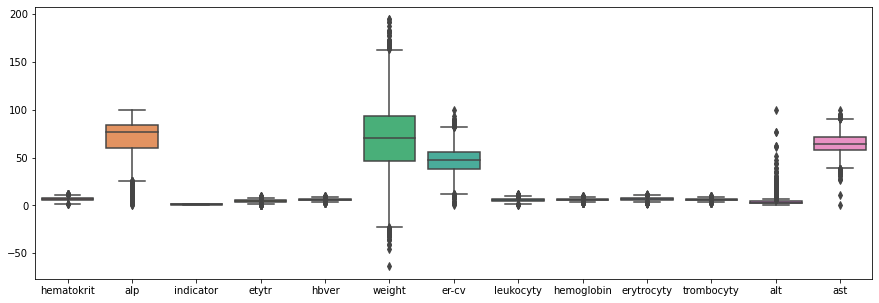

In [38]:
fig, ax = plt.subplots(figsize = (15, 5))
sns.boxplot(ax = ax, data = dataframe_merged);

Zobrazenie boxplotu, aby sme videli, kde máme outlierov a ako ďaleko sú od *normálnych* hodnôt.

In [39]:
dataframe_merged = __dataframe_load__()
dataframe_merged = __remove_outliers__(dataframe_merged, column_names)

Odstránenie outlierov.

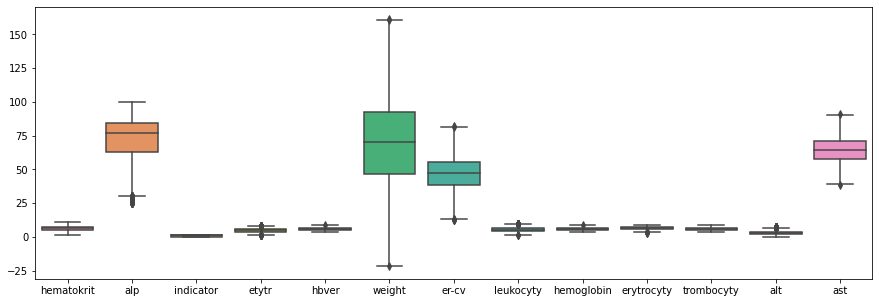

In [40]:
fig, ax = plt.subplots(figsize = (15, 5))
sns.boxplot(ax = ax, data = dataframe_merged);

Vizualizácia odstránenia outlierov pomocou boxplotu.

### 1.3 Nahradenie vychýlených hodnôt
Pomocou hraničných hodnôt rozdelenia (5% resp. 95%)

In [41]:
dataframe_merged = __dataframe_load__()

element = dataframe_merged.select_dtypes(exclude = "O")
for column_name in element.columns.values:
    print(column_name , " " *(20 - len(column_name)), 
          len(__identify_outliers__(element[column_name])))  

hematokrit            17
alp                   389
indicator             0
etytr                 142
hbver                 60
weight                66
er-cv                 69
leukocyty             61
hemoglobin            73
erytrocyty            66
trombocyty            81
alt                   761
ast                   70


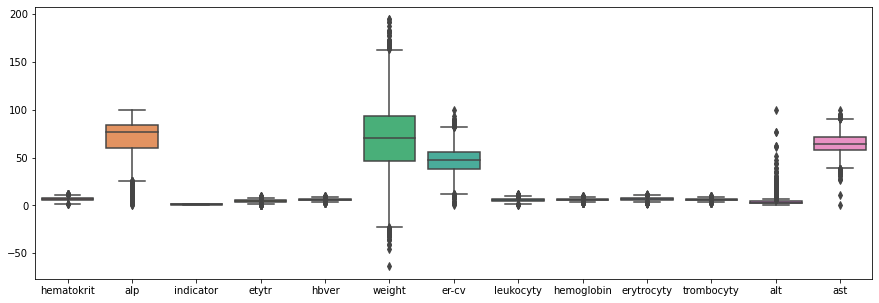

In [42]:
fig, ax = plt.subplots(figsize = (15, 5))
sns.boxplot(ax = ax, data = dataframe_merged);

In [43]:
# Načítame si zase dataset, aby neboli modifikované outliery
dataframe_merged = __dataframe_load__()
dataframe_merged = __replace_outliers__(dataframe_merged, column_names)

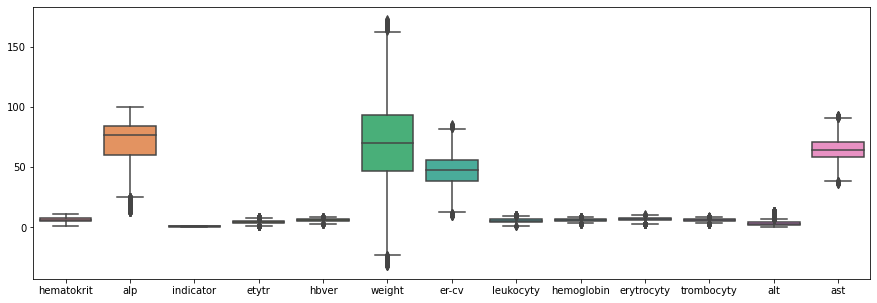

In [44]:
fig, ax = plt.subplots(figsize = (15, 5))
sns.boxplot(ax = ax, data = dataframe_merged);

Vizualizácia nahradenia outlierov.

## 2. Realizácia predspracovania dát


*	Transformované dáta pre strojové učenie si rozdeľuje na trénovaciu a testovaciu množinu (train and test dataset) podľa vami preddefinovaným pomerom. Naďalej pracujte len s trénovacím datasetom.

*	Transformujte atribútov dát pre strojové učenie podľa dostupných techník (minimálne 2 techniky) ako scaling, transformers a ďalšie.

* Zdôvodnite Vašu voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)


In [30]:
dataframe_merged = __run_test__()
y = dataframe_merged['indicator']
x = dataframe_merged.drop(['indicator'], axis = 1)

In [35]:
y

,relationship,hematokrit,alp,indicator,etytr,hbver,weight,er-cv,leukocyty,hemoglobin,erytrocyty,trombocyty,smoker,alt,ast,age,sex,blood_group,address,race
0,1,7.98605,35.91472,1.0,4.85635,5.253990,96.25994,55.94441,7.02066,4.40427,6.68671,6.64113,0,1.91308,67.79048,48,1,1,26654,1
1,2,4.93283,75.33679,0.0,5.59998,7.615305,29.51229,41.61444,4.59915,5.47178,5.24719,5.18076,1,2.37623,86.15844,48,1,1,26654,1
2,1,3.55419,69.49522,0.0,5.36091,6.443530,19.56509,35.15155,5.53585,7.15290,5.48525,6.57866,0,1.74182,62.48992,48,1,1,26654,1
3,2,6.66681,85.35914,0.0,3.96933,5.439040,96.56157,34.88919,3.95987,6.60966,7.55754,7.72454,0,2.89576,61.97566,48,1,1,26654,1
4,1,8.22106,58.60041,1.0,7.71875,5.431130,126.63454,41.97542,5.55075,4.91791,7.17856,5.93911,0,2.81644,56.21061,106,1,1,59945,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9909,1,3.89685,93.14603,0.0,5.08398,7.886790,58.06240,44.65609,4.45381,6.36601,5.14408,6.93247,1,3.01050,63.25188,61,0,7,97588,3
9910,1,6.59997,49.85381,0.0,3.73616,4.626390,54.45439,38.85242,4.45205,7.85399,6.49280,7.93319,1,2.28674,60.38192,61,0,7,97588,3
9911,2,5.80191,81.75472,1.0,3.49078,5.220940,46.21544,39.44599,5.41345,5.77036,7.76158,7.56625,0,3.73036,51.24002,43,1,1,62101,3
9912,2,6.58396,81.76228,1.0,5.16443,6.702610,115.13958,31.91107,9.73708,6.31056,7.04939,6.47440,0,3.58891,68.88487,43,1,1,62101,3


In [46]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1)

Vytvorenie x_train a y_train, s ktorými budeme pracovať v transformácií. Simulovanie použitím RobustScalera.

In [47]:
x_train

,relationship,hematokrit,alp,etytr,hbver,weight,er-cv,leukocyty,hemoglobin,erytrocyty,trombocyty,smoker,alt,ast,age,sex,blood_group,address,race
9180,2,5.41576,76.85076,3.88112,6.59530,57.50433,35.54972,5.10561,5.68399,5.45547,5.50680,0,2.62181,78.178340,75,0,4,40667,6
1748,1,7.31027,84.16100,5.26015,6.29876,50.49642,50.04499,7.48110,5.61856,7.37673,4.25304,0,2.97079,59.482690,101,0,2,87848,1
6220,1,5.41937,64.61673,4.35207,6.38717,25.75381,68.35504,4.58714,7.43208,6.89450,6.17017,1,3.03556,68.021990,14,0,8,92529,2
8958,2,7.93940,58.74755,6.03978,4.66531,46.18590,42.04681,7.16360,5.01624,7.18200,4.18904,1,2.51478,48.706958,111,0,8,44669,3
8237,2,5.04081,84.77799,4.53349,4.39604,91.03368,40.29861,4.69543,6.12874,6.97394,7.69970,0,2.07417,69.558060,45,1,1,8287,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,3,6.31723,32.14089,4.88031,7.11488,102.02296,51.92647,8.94089,4.30515,7.53630,5.97326,0,3.06393,62.781910,58,1,1,19279,4
7813,2,2.87498,55.61321,4.40754,8.00802,71.62825,66.86464,5.75331,5.04120,5.00047,6.93660,0,3.16117,74.788040,35,1,1,81611,3
905,3,7.11224,82.24018,3.79807,5.12172,26.59193,46.27083,3.72297,5.70078,7.36199,7.10824,1,4.11024,68.061610,12,0,5,15537,2
5192,1,6.04983,88.01510,3.18369,7.38229,96.11287,51.50437,6.20995,6.52910,3.53026,5.04244,0,3.06935,71.869820,102,1,1,37627,3


In [48]:
trained_scaling = pd.DataFrame(RobustScaler().fit_transform(x_train), columns = x_train.columns)
trained_scaling.head()

,relationship,hematokrit,alp,etytr,hbver,weight,er-cv,leukocyty,hemoglobin,erytrocyty,trombocyty,smoker,alt,ast,age,sex,blood_group,address,race
0,0.0,-0.387618,0.011461,-0.521582,0.464233,-0.268253,-0.678303,-0.048036,-0.204036,-0.783052,-0.349420,0.0,-0.157683,1.060621,0.298246,-1.0,0.0,-0.189559,3.0
1,-1.0,0.395025,0.325793,0.330581,0.251539,-0.419664,0.162409,1.118719,-0.253395,0.285880,-1.268926,0.0,0.023773,-0.394637,0.754386,-1.0,-0.4,0.749796,-2.0
2,-1.0,-0.386127,-0.514590,-0.230561,0.314951,-0.954247,1.224374,-0.302690,1.114680,0.017581,0.137094,1.0,0.057450,0.270057,-0.771930,-1.0,0.8,0.842993,-1.0
3,0.0,0.654926,-0.766958,0.812349,-0.920052,-0.512796,-0.301478,0.962775,-0.707770,0.177538,-1.315864,1.0,-0.213334,-1.233414,0.929825,-1.0,0.8,-0.109881,0.0
4,0.0,-0.542514,0.352323,-0.118454,-1.113186,0.456174,-0.402872,-0.249501,0.131473,0.061779,1.258849,0.0,-0.442433,0.389624,-0.228070,0.0,-0.6,-0.834233,3.0


Použitie škálovania metódou RobustScaler.

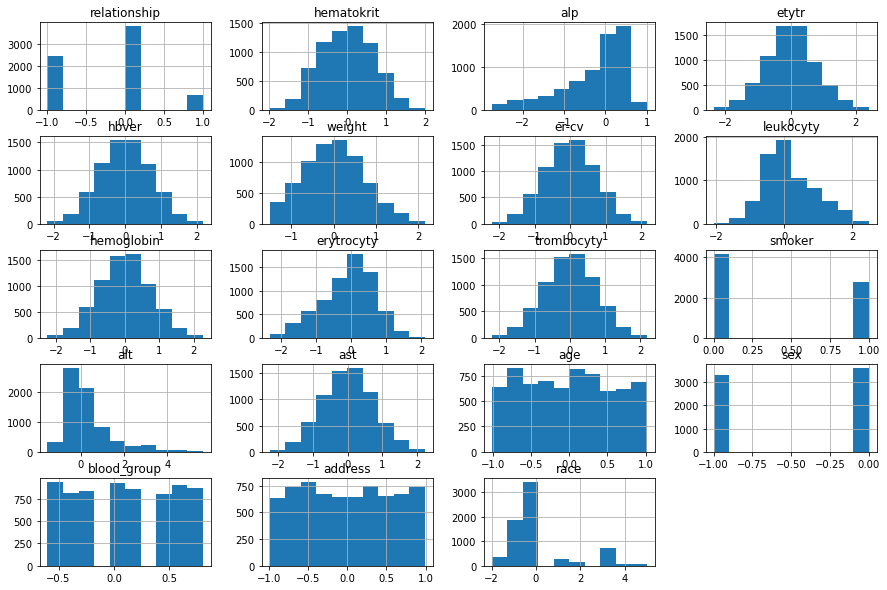

In [49]:
plt.rcParams['figure.figsize'] = [15, 10]
fig = trained_scaling.hist()

Zobrazenie histogramov po škálovaní.

In [50]:
dataframe_merged = __run_test__()
y = dataframe_merged['indicator']
x = dataframe_merged.drop(['indicator'], axis = 1)

In [51]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1)

Vytvorenie x_train a y_train, s ktorými budeme pracovať v transformácií. Simulovanie Powertransformera.

In [52]:
x_train

,relationship,hematokrit,alp,etytr,hbver,weight,er-cv,leukocyty,hemoglobin,erytrocyty,trombocyty,smoker,alt,ast,age,sex,blood_group,address,race
9180,2,5.41576,76.85076,3.88112,6.59530,57.50433,35.54972,5.10561,5.68399,5.45547,5.50680,0,2.62181,78.178340,75,0,4,40667,6
1748,1,7.31027,84.16100,5.26015,6.29876,50.49642,50.04499,7.48110,5.61856,7.37673,4.25304,0,2.97079,59.482690,101,0,2,87848,1
6220,1,5.41937,64.61673,4.35207,6.38717,25.75381,68.35504,4.58714,7.43208,6.89450,6.17017,1,3.03556,68.021990,14,0,8,92529,2
8958,2,7.93940,58.74755,6.03978,4.66531,46.18590,42.04681,7.16360,5.01624,7.18200,4.18904,1,2.51478,48.706958,111,0,8,44669,3
8237,2,5.04081,84.77799,4.53349,4.39604,91.03368,40.29861,4.69543,6.12874,6.97394,7.69970,0,2.07417,69.558060,45,1,1,8287,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,3,6.31723,32.14089,4.88031,7.11488,102.02296,51.92647,8.94089,4.30515,7.53630,5.97326,0,3.06393,62.781910,58,1,1,19279,4
7813,2,2.87498,55.61321,4.40754,8.00802,71.62825,66.86464,5.75331,5.04120,5.00047,6.93660,0,3.16117,74.788040,35,1,1,81611,3
905,3,7.11224,82.24018,3.79807,5.12172,26.59193,46.27083,3.72297,5.70078,7.36199,7.10824,1,4.11024,68.061610,12,0,5,15537,2
5192,1,6.04983,88.01510,3.18369,7.38229,96.11287,51.50437,6.20995,6.52910,3.53026,5.04244,0,3.06935,71.869820,102,1,1,37627,3


In [53]:
trained_power = __transform__(x_train, x_train.columns)

<ipython-input-14-6e25ea0f5094>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[col] = power.fit_transform(data)
<ipython-input-14-6e25ea0f5094>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[col] = power.fit_transform(data)
<ipython-input-14-6e25ea0f5094>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Využitie transformácie pomocou PowerTransformera metódou yeo-johnson, pretotože sa dokáže vysporiadať aj s mínusovými hodnotami.

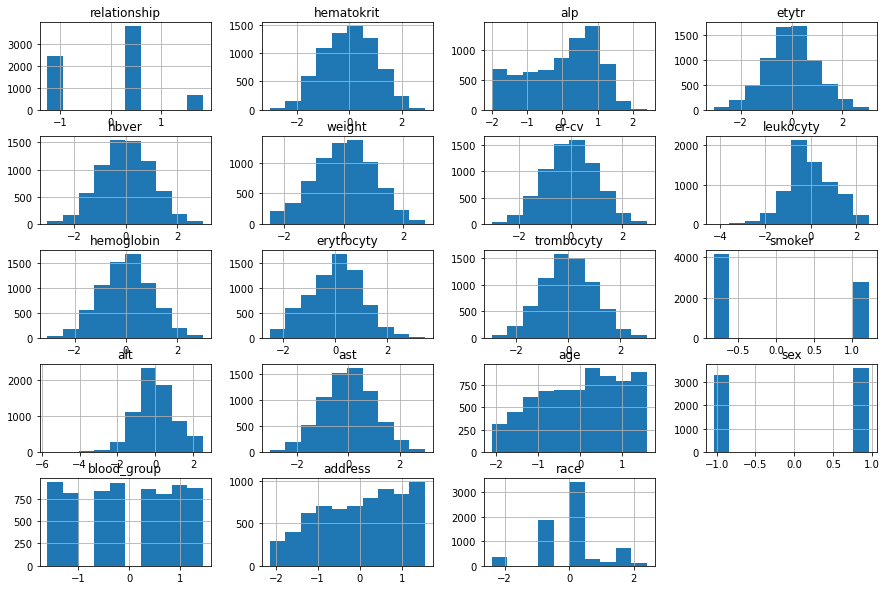

In [54]:
plt.rcParams['figure.figsize'] = [15, 10]
fig = trained_power.hist()

Zobrazenie histogramov po použití PowerTransformera.

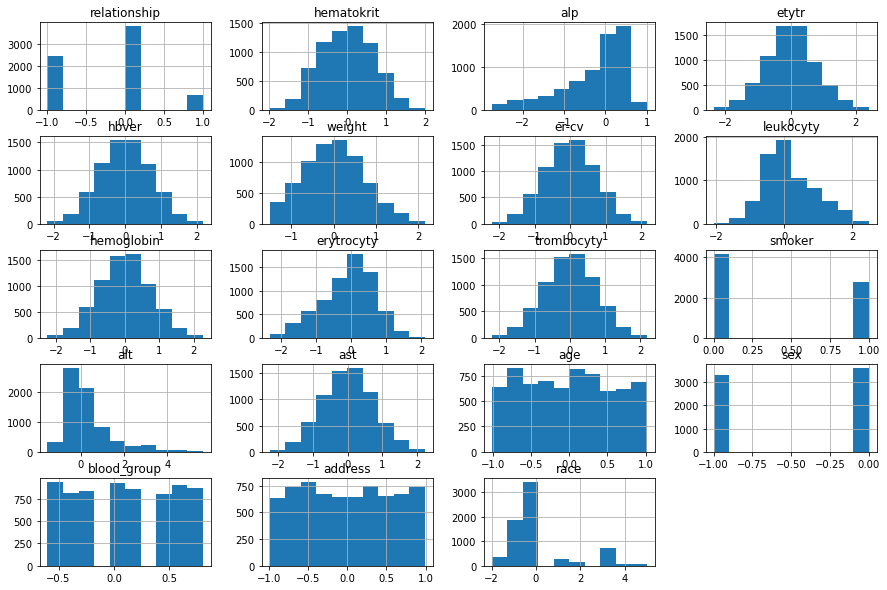

In [55]:
plt.rcParams['figure.figsize'] = [15, 10]
fig = trained_scaling.hist()

Pri porovnaní týchto dvoch metód transformácie vidíme jeden značný rozdiel pri hodnote ALP, kde sú nie veĺmi podobné histogramy. My použijeme PowerTransformera v Pipeline, týmto sme chceli simulovať, že dokážeme obidve metódy, ale vyberáme si metódu Yeo-johnson PowerTransformera.

## 3. Výber atribútov pre strojové učenie


*	Zistite ktoré atribúty (features) vo vašich dátach pre strojové učenie sú informatívne k atribútu “indikator”. Zoradíte tie atribúty v poradí podľa dôležitosti.
    

*	Zdôvodnite Vašu voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)

In [1]:
df = SelectKBest(f_classif, k = 10)
df.fit(x_train, y_train)
cols = df.get_support(indices = True)
features_dataframe_new = x_train.iloc[:,cols]
features_dataframe_new

NameError: name 'SelectKBest' is not defined

Využitie metódy SelectKbest. Používame x_train z transformácie PowerTransformerom.

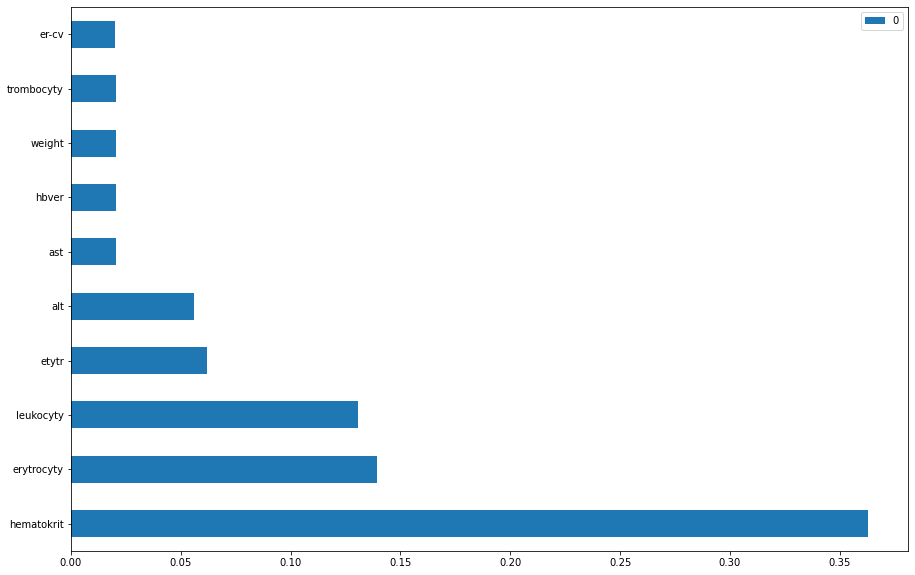

In [57]:
fi = ExtraTreesClassifier()
fi_a = fi.fit(x_train, y_train)

df_fi_a = pd.DataFrame(fi_a.feature_importances_, index = x_train.columns)
df_fi_a.nlargest(10, df_fi_a.columns).plot(kind = 'barh');

Využitie ExtraTressClassifier, kde narozdiel od SelectKbest, zobrazíme atribúty pre strojové učenie v grafe.

In [58]:
dataframe_default = __run__();
dataframe_default.corr()['indicator'].sort_values(ascending = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   relationship  9914 non-null   int64  
 1   hematokrit    9914 non-null   float64
 2   alp           9914 non-null   float64
 3   indicator     9914 non-null   float64
 4   etytr         9914 non-null   float64
 5   hbver         9914 non-null   float64
 6   weight        9914 non-null   float64
 7   er-cv         9914 non-null   float64
 8   leukocyty     9914 non-null   float64
 9   hemoglobin    9914 non-null   float64
 10  erytrocyty    9914 non-null   float64
 11  trombocyty    9914 non-null   float64
 12  smoker        9914 non-null   int64  
 13  alt           9914 non-null   float64
 14  ast           9914 non-null   float64
 15  age           9914 non-null   int64  
 16  sex           9914 non-null   int64  
 17  blood_group   9914 non-null   int64  
 18  address       9914 non-null 

indicator       1.000000
hematokrit      0.648359
erytrocyty      0.383892
leukocyty       0.318352
alt             0.285281
race            0.010711
weight          0.010160
age             0.002180
sex             0.001565
relationship    0.001314
smoker         -0.000541
etytr          -0.001689
address        -0.001890
blood_group    -0.002996
hbver          -0.004781
trombocyty     -0.004919
er-cv          -0.006034
ast            -0.006264
hemoglobin     -0.014989
alp            -0.019840
Name: indicator, dtype: float64

Ak si vyberieme finálny dataset, ktorý budeme používať, tak sa nám zhodujú zväčša postupností korelácií, ktoré sú viazané na indikátor. 
Takže pre strojové učenie vyberáme hematokrit, erytrocyty, leukocyty, alt, race, weight a možno aj viac do budúcna. Vyberáme ich preto, pretože máme najvyššie hodnoty korelácie s hodnotou indikátor.

In [59]:
default_dataset = __dataframe_load__()
default_dataset.corr()['indicator'].sort_values(ascending = False)

indicator     1.000000
hematokrit    0.645390
erytrocyty    0.397241
leukocyty     0.343648
alt           0.182968
weight        0.006700
etytr        -0.001946
hbver        -0.004769
trombocyty   -0.006153
er-cv        -0.007590
ast          -0.007652
hemoglobin   -0.015093
alp          -0.021187
Name: indicator, dtype: float64

Vidíme, že ak načítame pôvodný mergnutý dataset, kde nenastala žiadna transformácia ani úprava, tak vidíme, že hodnota korelácie indikátora s príslušnou premennou sa zmenila o pár hodnôt, pretože sme nahrádzali outlierov, NA hodnoty atď. kde sa nám hodnota koreĺacie mení.

## 4. Replikovateľnosť predspracovania


*	Upravte váš kód realizujúci predspracovanie trénovacej množiny tak, aby ho bolo možné bez ďalších úprav znovu použiť na predspracovanie testovacej množiny (napr. pomocou funkcie/í)
    

*	Očakáva sa aj využitie možnosti sklearn.pipeline

Znovupoužiteľnosť pomocou použitia pipeline a funkcií. Posielame do pipeline v poradí:

* integrácia a deduplikácia záznamov

* zbavenie sa NA hodnôt 

* zmena dát na numerické pomocou encodingu

* nahradenie outlierov pomocou percentilov

* transformácia pomocou power_transform

In [60]:
def __integration__(dataframe):
    dataframe = __dataframe_load__()
    dataframe = __unify_values__(dataframe)
    dataframe = __birthdate_to_date__(dataframe, 'birthdate')
    dataframe = __age_calculation__(dataframe, 'birthdate')
    dataframe = dataframe.rename(columns = {'birthdate': 'age'})
    dataframe = __positive__(dataframe, 'weight')
    dataframe = __zip__(dataframe, 'address')
    
    dataframe = dataframe.drop('name', 1)
    dataframe = dataframe.drop('residence', 1)
    dataframe = dataframe.drop('company', 1)
    dataframe = dataframe.drop('ssn', 1)
    
    return dataframe

V pipeline používame funkciu integration, kde sa nám načíta dataset, dopočíta vek, vyberieme PSČ a dropneme nepotrebné columns.

In [61]:
def __replace_NA__(dataframe):
    dataframe = __kNN__(dataframe, ['hematokrit', 'alp', 'etytr', 'hbver', 'er-cv','leukocyty'])
    dataframe = __fill_mean__(dataframe, ['hemoglobin', 'erytrocyty', 'trombocyty', 'alt', 'ast'])
    
    return dataframe

Pri replace NA hodnôt sme vybrali _knn_ algoritmus a vyplnenie meanom.

In [62]:
def __encode__(dataframe):
    dataframe = __encode_multiple__(dataframe)
    
    return dataframe

Enkódujeme kategorické hodnoty na numerické.

In [63]:
def __replace_outliers_pipe__(dataframe):
    dataframe = __replace_outliers__(dataframe, ['hematokrit', 'alp', 'etytr', 'hbver', 'er-cv','leukocyty', 
                'hemoglobin', 'erytrocyty', 'trombocyty', 'alt', 'ast', 'weight'])
    
    return dataframe

Náhrada outlierov pomocou metódy 5% a 95% kvartilu.

In [64]:
def __transform_pipe__(dataframe):
    dataframe = __transform__(dataframe, ['hematokrit', 'alp', 'etytr', 'hbver', 'er-cv','leukocyty', 
                'hemoglobin', 'erytrocyty', 'trombocyty', 'alt', 'ast'])
    
    return dataframe

Finálna transformácia pomocou PowerTransformera a metódy yeo-johnson.

In [65]:
df = None

pipeline = Pipeline([
    ('Integration', FunctionTransformer (func = __integration__)),
    ('NA_replace', FunctionTransformer (func = __replace_NA__)),
    ('Encode', FunctionTransformer (func = __encode__)),
    ('Replace_outliers', FunctionTransformer (func = __replace_outliers_pipe__)),
    ('Transform', FunctionTransformer (func = __transform_pipe__))
])

df = pipeline.fit_transform(df)
df.info()
df.to_csv('/Users/martinkatkovcin/Documents/School/Intelligent Data Analysis/Projekt/preprocessed_data/preprocessed_data.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   relationship  9914 non-null   int64  
 1   hematokrit    9914 non-null   float64
 2   alp           9914 non-null   float64
 3   indicator     9914 non-null   float64
 4   etytr         9914 non-null   float64
 5   hbver         9914 non-null   float64
 6   weight        9914 non-null   float64
 7   er-cv         9914 non-null   float64
 8   leukocyty     9914 non-null   float64
 9   hemoglobin    9914 non-null   float64
 10  erytrocyty    9914 non-null   float64
 11  trombocyty    9914 non-null   float64
 12  smoker        9914 non-null   int64  
 13  alt           9914 non-null   float64
 14  ast           9914 non-null   float64
 15  age           9914 non-null   int64  
 16  sex           9914 non-null   int64  
 17  blood_group   9914 non-null   int64  
 18  address       9914 non-null 

Finálny dataset použitím pipeline, kde ukladáme tento dataframe do preprocessed_data.csv.

In [66]:
__column_description__(df)

Column name: relationship
Number of values: 9914
Number of unique values: 3
Number of NA values: 0

Column name: hematokrit
Number of values: 9914
Number of unique values: 9819
Number of NA values: 0

Column name: alp
Number of values: 9914
Number of unique values: 9822
Number of NA values: 0

Column name: indicator
Number of values: 9914
Number of unique values: 2
Number of NA values: 0

Column name: etytr
Number of values: 9914
Number of unique values: 9763
Number of NA values: 0

Column name: hbver
Number of values: 9914
Number of unique values: 9746
Number of NA values: 0

Column name: weight
Number of values: 9914
Number of unique values: 9893
Number of NA values: 0

Column name: er-cv
Number of values: 9914
Number of unique values: 9874
Number of NA values: 0

Column name: leukocyty
Number of values: 9914
Number of unique values: 9797
Number of NA values: 0

Column name: hemoglobin
Number of values: 9914
Number of unique values: 9725
Number of NA values: 0

Column name: erytrocyt

Kontrola, či sa nahradili všetky NA values.

# 5. Porovnanie datasetov (pôvodný merged a preprocessed data)

In [67]:
default_dataset

,relationship,hematokrit,alp,indicator,etytr,hbver,weight,er-cv,leukocyty,hemoglobin,...,ssn,ast,residence,name,company,birthdate,sex,blood_group,address,race
0,married,7.98605,35.91472,1.0,4.85635,5.25399,96.25994,55.94441,7.02066,4.40427,...,126-67-1124,67.79048,"2748 William Underpass\nWest Warren, WY 64316",Rachel Bridges,Wagner-Aguilar,1973-01-12,F,B+,"623 Willis Spurs Suite 594\nPort Stephanie, AK...",Indian
1,divoced,4.93283,75.33679,0.0,5.59998,9.27414,29.51229,41.61444,4.59915,5.47178,...,126-67-1124,86.15844,"2748 William Underpass\nWest Warren, WY 64316",Rachel Bridges,Wagner-Aguilar,1973-01-12,F,B+,"623 Willis Spurs Suite 594\nPort Stephanie, AK...",Indian
2,married,3.55419,69.49522,0.0,5.36091,6.44353,19.56509,35.15155,5.53585,7.15290,...,126-67-1124,62.48992,"2748 William Underpass\nWest Warren, WY 64316",Rachel Bridges,Wagner-Aguilar,1973-01-12,F,B+,"623 Willis Spurs Suite 594\nPort Stephanie, AK...",Indian
3,divoced,6.66681,85.35914,0.0,3.96933,5.43904,96.56157,34.88919,3.95987,6.60966,...,126-67-1124,61.97566,"2748 William Underpass\nWest Warren, WY 64316",Rachel Bridges,Wagner-Aguilar,1973-01-12,F,B+,"623 Willis Spurs Suite 594\nPort Stephanie, AK...",Indian
4,married,8.22106,58.60041,1.0,7.71875,5.43113,126.63454,41.97542,5.55075,4.91791,...,358-62-3858,56.21061,"43671 Jeremy Dale\nNew Cynthia, RI 59099",Nicole Henderson,Dunn-Willis,20 Jul 1915,F,B+,"730 Kevin Coves\nWilliamborough, WV 59945",Black
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9909,separated,3.89685,93.14603,0.0,5.08398,7.88679,58.06240,44.65609,4.45381,6.36601,...,574-86-8675,63.25188,USCGC Deleon\nFPO AA 89489,Joseph Nguyen,Harrison-Melton,"10/25/1960, 00:00:00",M,A-,"8431 Edwards Skyway\nTannermouth, LA 97588",White
9910,married,6.59997,49.85381,0.0,3.73616,4.62639,54.45439,38.85242,4.45205,7.85399,...,574-86-8675,60.38192,USCGC Deleon\nFPO AA 89489,Joseph Nguyen,Harrison-Melton,"10/25/1960, 00:00:00",M,A-,"8431 Edwards Skyway\nTannermouth, LA 97588",White
9911,single,5.80191,81.75472,1.0,3.49078,5.22094,46.21544,39.44599,5.41345,5.77036,...,697-01-8204,51.24002,"004 Tony Turnpike\nAdamshire, NY 22194",Jasmine Diaz MD,Thompson Inc,07 Nov 1978,F,B+,"PSC 0124, Box 9795\nAPO AA 62101",White
9912,divoced,6.58396,81.76228,1.0,5.16443,6.70261,115.13958,31.91107,9.73708,6.31056,...,697-01-8204,68.88487,"004 Tony Turnpike\nAdamshire, NY 22194",Jasmine Diaz MD,Thompson Inc,07 Nov 1978,F,B+,"PSC 0124, Box 9795\nAPO AA 62101",White


In [68]:
__column_description__(default_dataset)

Column name: relationship
Number of values: 9914
Number of unique values: 6
Number of NA values: 0

Column name: hematokrit
Number of values: 9914
Number of unique values: 9805
Number of NA values: 30

Column name: alp
Number of values: 9914
Number of unique values: 9880
Number of NA values: 30

Column name: indicator
Number of values: 9914
Number of unique values: 2
Number of NA values: 0

Column name: etytr
Number of values: 9914
Number of unique values: 9777
Number of NA values: 30

Column name: hbver
Number of values: 9914
Number of unique values: 9741
Number of NA values: 30

Column name: weight
Number of values: 9914
Number of unique values: 9911
Number of NA values: 0

Column name: er-cv
Number of values: 9914
Number of unique values: 9878
Number of NA values: 30

Column name: leukocyty
Number of values: 9914
Number of unique values: 9787
Number of NA values: 30

Column name: hemoglobin
Number of values: 9914
Number of unique values: 9754
Number of NA values: 30

Column name: er

V pôvodonom datasete sme našli NA hodnoty.

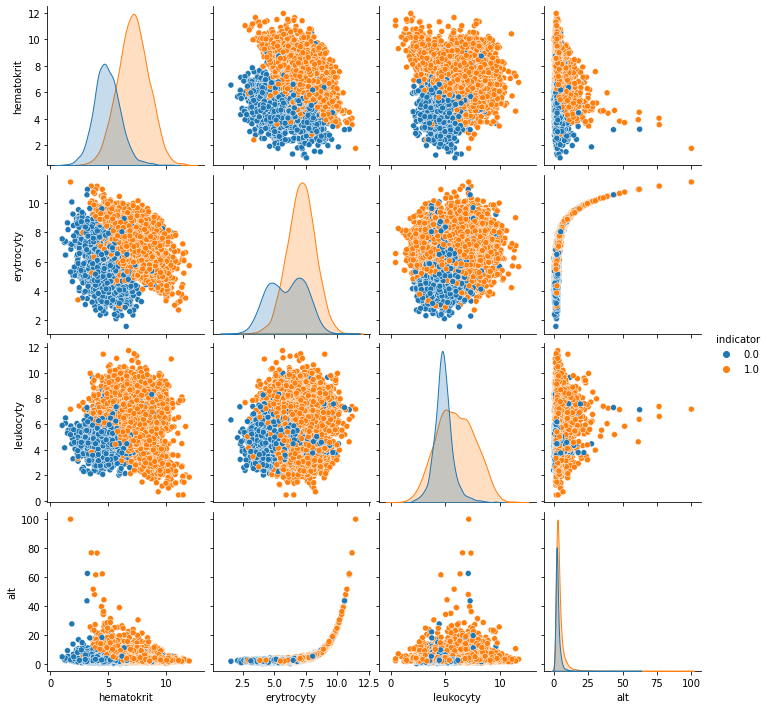

In [69]:
sns.pairplot(default_dataset[['hematokrit', 'erytrocyty', 'leukocyty', 'alt', 'indicator']], hue = "indicator");

Pôvodný dataset korelácie znázornené.

In [70]:
df

,relationship,hematokrit,alp,indicator,etytr,hbver,weight,er-cv,leukocyty,hemoglobin,erytrocyty,trombocyty,smoker,alt,ast,age,sex,blood_group,address,race
0,1,1.002078,-1.690945,1.0,0.095394,-0.691543,96.25994,0.692012,0.967920,-1.539873,-0.081425,0.662680,0,-0.937831,0.350561,48,1,1,26654,1
1,2,-0.845888,0.142847,0.0,0.680518,1.662009,29.51229,-0.435552,-0.543374,-0.469814,-1.098593,-0.786629,1,-0.478210,2.252746,48,1,1,26654,1
2,1,-1.719087,-0.255660,0.0,0.492401,0.496301,19.56509,-0.950673,0.091275,1.206636,-0.940456,0.600370,0,-1.138151,-0.206097,48,1,1,26654,1
3,2,0.215692,0.943647,0.0,-0.602481,-0.506430,96.56157,-0.971686,-1.024702,0.665944,0.602715,1.747310,0,-0.068096,-0.260312,48,1,1,26654,1
4,1,1.140521,-0.873149,1.0,2.347931,-0.514340,126.63454,-0.406915,0.100794,-1.024407,0.298772,-0.035986,0,-0.124982,-0.870779,106,1,1,59945,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9909,1,-1.499172,1.673400,0.0,0.274499,1.931534,58.06240,-0.194660,-0.648974,0.423127,-1.165817,0.953616,1,0.011041,-0.125838,61,0,7,97588,3
9910,1,0.175401,-1.258538,0.0,-0.785916,-1.320346,54.45439,-0.655125,-0.650266,1.903121,-0.226825,1.957019,1,-0.559015,-0.428574,61,0,7,97588,3
9911,2,-0.309386,0.638135,1.0,-0.978949,-0.724618,46.21544,-0.607868,0.012453,-0.171342,0.770265,1.588388,0,0.436849,-1.401378,43,1,1,62101,3
9912,2,0.165743,0.638755,1.0,0.337800,0.754390,115.13958,-1.210832,2.293084,0.367839,0.197354,0.496436,0,0.361545,0.465024,43,1,1,62101,3


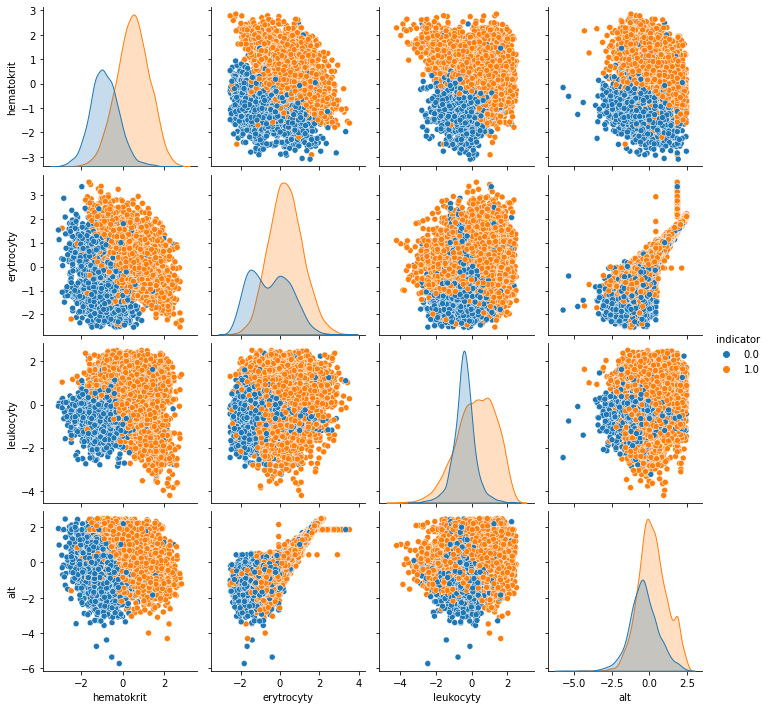

In [71]:
sns.pairplot(df[['hematokrit', 'erytrocyty', 'leukocyty', 'alt', 'indicator']], hue = 'indicator')

Výsledný dataset korelácie po úprave.

In [72]:
__column_description__(df)

Column name: relationship
Number of values: 9914
Number of unique values: 3
Number of NA values: 0

Column name: hematokrit
Number of values: 9914
Number of unique values: 9819
Number of NA values: 0

Column name: alp
Number of values: 9914
Number of unique values: 9822
Number of NA values: 0

Column name: indicator
Number of values: 9914
Number of unique values: 2
Number of NA values: 0

Column name: etytr
Number of values: 9914
Number of unique values: 9763
Number of NA values: 0

Column name: hbver
Number of values: 9914
Number of unique values: 9746
Number of NA values: 0

Column name: weight
Number of values: 9914
Number of unique values: 9893
Number of NA values: 0

Column name: er-cv
Number of values: 9914
Number of unique values: 9874
Number of NA values: 0

Column name: leukocyty
Number of values: 9914
Number of unique values: 9797
Number of NA values: 0

Column name: hemoglobin
Number of values: 9914
Number of unique values: 9725
Number of NA values: 0

Column name: erytrocyt

V upravenom datasete nemáme žiadne NA values.

# 6. Zhodnotenie

V tomto zadaní sa nám podarilo pomocou rôznych funkcií vytvoriť výsledný dataset, ktorý sme si uložili, a ktorý budeme používať pre strojové učenie. Podarilo sa nám vybratie atribútov, následné porovnanie hodnoty korelácií medzi pôvodným datasetom a medzi upraveným finálnym dataseteom.